# Bayesian Correlated t-test
Module `correlated_ttest` in `bayesiantests` can be used to perform the correlated t-test on the performance of two classifiers that have been assessed by $m$-runs of $k$-fold cross-validation  on the same dataset

This notebook demonstrates the use of the module.


We will load the classification accuracies of the naive Bayesian classifier (NBC) and AODE on the dataset *Anneal* from the file `Data/nbc_anneal.csv` and `Data/aode_anneal.csv`.  The classifiers have been evaluated by 10-runs of 10-fold cross-validation.

In [ ]:
import numpy as np
Acc_nbc =  np.loadtxt('Data/nbc_anneal.csv',  delimiter=',', skiprows=1)
Acc_aode = np.loadtxt('Data/aode_anneal.csv', delimiter=',', skiprows=1)
names = ("AODE", "NBC")
x=np.zeros((len(Acc_nbc),2),'float')
x[:,0]=Acc_aode/100
x[:,1]=Acc_nbc/100
#we consider the difference of accuracy scaled in (0,1)

In [596]:
import os
import pandas as pd
import numpy as np
import pickle
import NNcomp
from importlib import reload

In [597]:
reload(NNcomp)

<module 'NNcomp' from '/home/ldap/ipellet/Documents/NN/BayesianTestsML/Python/NNcomp.py'>

In [585]:
res_dir = '../../results/'
for root, dirs, files in os.walk(res_dir):
    res_ = [f.removesuffix('.csv') for f in files]
    res_path = [os.path.join(res_dir,r) for r in files]
    break

In [624]:
res_short = ['fcNN', 'reactome']
for r in res_[2:]:
    res_short.append('_'.join(r.split('_')[:2]))

In [625]:
res_df = []
nLines = []
for i in range(len(res_)):
    df = pd.read_csv(res_path[i], index_col=0)
    nLines.append(df.shape[0])
    #solcol = pd.Series([res_[i]]*df.shape[0], name='Sol')
    res_df.append(df)
solcol = pd.Series(np.repeat(res_short, nLines, axis=0), name='Sol')
tmp = pd.concat(res_df, axis=0, ignore_index=True)
all_res = pd.concat([tmp,solcol], axis=1)
del tmp, nLines, df, solcol

In [629]:
metrics = res_df[0].columns
metric_scores = {}
for m in metrics:
    metric_scores[m] = NNcomp.getMetric(res_df, res_short, m)

In [631]:
f = open('./metric_scores.txt', 'br')
metric_scores = pickle.load(f)
f.close()

In [632]:
m = 'AUC'
i0 = 5
i1 = 2
x = metric_scores[m].iloc[[i0,i1],:].to_numpy().T
names = metric_scores[m].index[[i0,i1]].values

Functions in the module accept the following arguments.

- `x`: a 2-d array with scores of two models (each row corresponding to a data set) or a vector of differences.
- `rope`: the region of practical equivalence. We consider two classifiers equivalent if the difference in their performance is smaller than `rope`. 
- `runs`:  number of repetitions of cross validation 
- `names`: the names of the two classifiers; if `x` is a vector of differences, positive values mean that the second (right) model had a higher score.
- `verbose`: when True the functions also prints out the probabilities

In [635]:
import bayesiantests as bt
rope=0.01
left, within, right = bt.correlated_ttest(x, rope=rope,runs=10,verbose=True,names=names)

P(WGCNA_g2v > ICA_rna) = 0.9600169653829631, P(rope) = 0.03899936323192443, P(ICA_rna > WGCNA_g2v) = 0.0009836713851124612


In [636]:
cor_ttest_metrics = {}
for m in metric_scores:
    cor_ttest_ = []
    for i0 in range(metric_scores[m].shape[0]-1):
        for i1 in range(i0+1, metric_scores[m].shape[0]):
            x = metric_scores[m].iloc[[i0,i1],:].to_numpy().T
            names = metric_scores[m].index[[i0,i1]].values.tolist()
            samples = bt.correlated_ttest(x, rope=rope,runs=10,verbose=False,names=names)
            line = names
            line.extend(samples)
            cor_ttest_.append(line)
    cor_ttest_metrics[m] = pd.DataFrame(cor_ttest_, columns=['a','b','P(a>b)','P(rope)','P(b>a)'])

In [637]:
import seaborn as sns

In [650]:
n = 100
rank_m = {}
for m in metric_scores:
    A = res_short
    rank = {s:[] for s in res_short}
    for n in range(n):
        NNcomp.quicksort(A, 0, len(A)-1, cor_ttest_metrics[m])
        for i,s in enumerate(A):
            rank[s].append(i)
    rank_m[m] = rank

In [724]:
df_ = []
for m in rank_m:
    for nn in rank_m[m]:
        df = pd.DataFrame([[nn]*n, [m]*n, rank_m[m][nn]], index=['NN', 'Metric', 'Rank']).T
        df_.append(df)

In [725]:
rank_all = pd.concat(df_, ignore_index=True)

In [726]:
rank_all

,NN,Metric,Rank
0,WGCNA_g2v,AUC,4
1,WGCNA_g2v,AUC,8
2,WGCNA_g2v,AUC,5
3,WGCNA_g2v,AUC,5
4,WGCNA_g2v,AUC,3
...,...,...,...
17995,KMeans_g2v,MCC,7
17996,KMeans_g2v,MCC,5
17997,KMeans_g2v,MCC,5
17998,KMeans_g2v,MCC,11


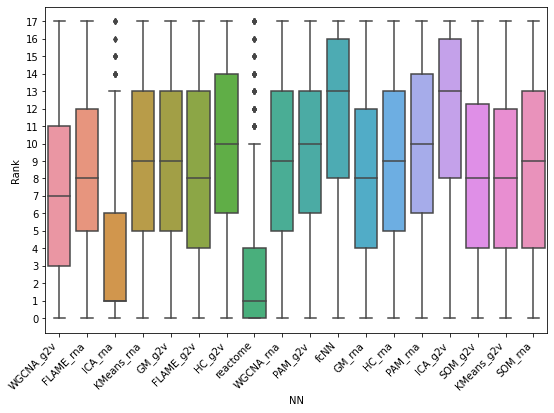

In [727]:
#res = plt.boxplot(df_sorted, labels=df_sorted.columns)
g = sns.boxplot(data=rank_all, x='NN', y='Rank', fliersize=4)
plt.xticks(rotation=45, ha='right')
plt.yticks([i for i in range(18)])
plt.ylabel('Rank'); 
#plt.savefig('/home/ldap/ipellet/Documents/img/NN_rank.png', bbox_inches='tight');

In [736]:
rank_all.groupby('NN').median().sort_values('Rank', ascending=False)

,Rank
NN,
fcNN,13.0
ICA_g2v,13.0
PAM_rna,10.0
HC_g2v,10.0
PAM_g2v,10.0
KMeans_rna,9.0
GM_g2v,9.0
HC_rna,9.0
WGCNA_rna,9.0


In [651]:
rank_med_m = {}
for m in metric_scores:
    rank_med = {}
    for s in rank_m[m]:
        rank_med[s] = np.median(rank_m[m][s])
    rank_med_m[m] = rank_med

In [652]:
rank_med_df = pd.DataFrame(rank_med_m)

In [733]:
rank_med_df

,AUC,Accuracy,Specificity,Sensitivity,Precision,Recall,F1,balanced_accuracy,cohen_kappa,MCC
WGCNA_g2v,7.0,5.0,6.0,7.0,9.0,7.0,7.0,7.5,6.5,8.0
FLAME_rna,9.5,8.0,10.0,8.0,9.0,6.5,10.0,7.0,9.0,7.0
ICA_rna,1.0,1.0,9.0,2.0,2.0,2.0,3.5,1.0,1.0,1.0
KMeans_rna,10.0,10.0,5.0,10.5,8.0,11.0,9.5,11.0,7.0,9.0
GM_g2v,10.0,8.0,9.0,8.5,9.0,9.0,7.0,9.0,8.0,8.0
FLAME_g2v,11.0,8.0,10.5,5.0,11.0,7.0,7.0,7.0,7.5,7.5
HC_g2v,12.0,11.0,10.0,10.5,11.0,7.0,8.0,9.0,9.0,11.0
reactome,0.0,0.0,12.5,0.0,2.0,1.0,0.0,0.0,0.0,0.0
WGCNA_rna,5.0,10.0,8.0,10.0,9.0,11.0,11.0,10.0,9.0,10.0
PAM_g2v,13.0,10.0,8.0,10.0,9.0,9.0,9.0,9.0,11.0,9.0


In [653]:
df = rank_med_df.T
sorted_index = df.median().sort_values(ascending=False).index
df_sorted=df[sorted_index]

In [654]:
Q1 = pd.Series(np.quantile(df_sorted, 0.25, axis=0), index=df_sorted.columns, name='Q1')
Q3 = pd.Series(np.quantile(df_sorted, 0.75, axis=0), index=df_sorted.columns, name='Q3')
IQR = Q3-Q1

In [655]:
low = Q1-1.5*IQR
high = Q3+1.5*IQR
low_df = df_sorted<low
high_df = df_sorted>high

In [656]:
etiquettes = []
for i,col in enumerate(df_sorted):
    outliers_low = df_sorted.index[low_df[col]].values.tolist() 
    outliers_high = df_sorted.index[high_df[col]].values.tolist()
    for o in outliers_low:
        etiquettes.append((o[:3],i,df_sorted.at[o,col],-1))
    for o in outliers_high:
        etiquettes.append((o[:3],i,df_sorted.at[o,col],1))

In [661]:
etiquettes

[('Spe', 0, 2.0, -1),
 ('Spe', 2, 5.0, -1),
 ('AUC', 5, 5.0, -1),
 ('Spe', 6, 5.0, -1),
 ('AUC', 7, 6.0, -1),
 ('Spe', 7, 5.0, -1),
 ('AUC', 8, 5.0, -1),
 ('AUC', 9, 13.0, 1),
 ('Acc', 15, 5.0, -1),
 ('Pre', 15, 9.0, 1),
 ('Spe', 16, 9.0, 1),
 ('Spe', 17, 12.5, 1),
 ('Pre', 17, 2.0, 1)]

In [669]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

In [679]:
plt.rcParams['figure.figsize'] = 9,6

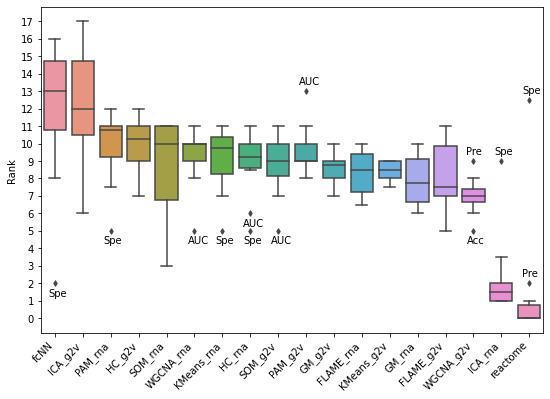

In [691]:
#res = plt.boxplot(df_sorted, labels=df_sorted.columns)
g = sns.boxplot(data=df_sorted, fliersize=4)
plt.xticks(rotation=45, ha='right')
s = None
for e in etiquettes:
    #if s==e[1]:
    #    yoff2 = -1
    #else:
    yoff2 = 0
    xoffset = -0.25
    if e[3]>0:
        yoffset = 0.40
    else:
        yoffset = -0.75+yoff2
    plt.text(e[1]+xoffset,e[2]+yoffset,e[0], size=10)
    s = e[1]
plt.yticks([i for i in range(18)])
plt.ylabel('Rank'); 
plt.savefig('/home/ldap/ipellet/Documents/img/NN_rank.png', bbox_inches='tight');

In [749]:
ordered_models=df_sorted.columns.values.tolist()

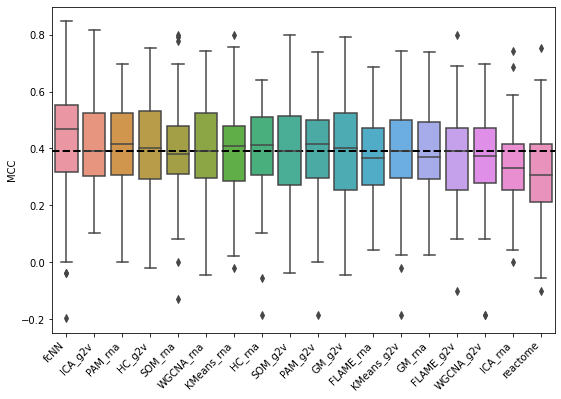

In [757]:
for i,m in enumerate(metrics):    
    plt.clf()
    g = sns.boxplot( x=all_res["Sol"], y=all_res[m], order=ordered_models)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
    med = np.median(all_res[m])
    plt.hlines(med, ls='--', xmin=plt.xlim()[0], xmax=plt.xlim()[1], color = '0', lw=2)
    #ax.set_ylim((-1,1))
    plt.xlabel("Sol", visible=False)
    #if i//nCol != nrow-1:
    #    plt.setp(ax.get_xticklabels(), visible=False)
    plt.savefig('/home/ldap/ipellet/Documents/img/NN_'+str(m)+'_boxplot.png', transparent=True, bbox_inches='tight')

[Text(0, 0, 'fcNN'),
 Text(1, 0, 'ICA_g2v'),
 Text(2, 0, 'PAM_rna'),
 Text(3, 0, 'HC_g2v'),
 Text(4, 0, 'SOM_rna'),
 Text(5, 0, 'WGCNA_rna'),
 Text(6, 0, 'KMeans_rna'),
 Text(7, 0, 'HC_rna'),
 Text(8, 0, 'SOM_g2v'),
 Text(9, 0, 'PAM_g2v'),
 Text(10, 0, 'GM_g2v'),
 Text(11, 0, 'FLAME_rna'),
 Text(12, 0, 'KMeans_g2v'),
 Text(13, 0, 'GM_rna'),
 Text(14, 0, 'FLAME_g2v'),
 Text(15, 0, 'WGCNA_g2v'),
 Text(16, 0, 'ICA_rna'),
 Text(17, 0, 'reactome')]

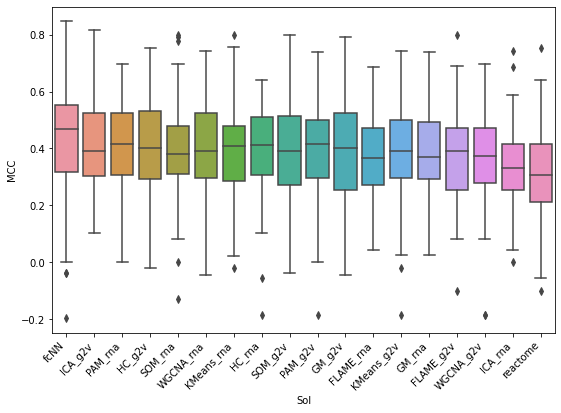

In [751]:
g = sns.boxplot( x=all_res["Sol"], y=all_res[m], order=ordered_models)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')

In [745]:
IQR[2:-2]

PAM_rna       1.750
HC_g2v        2.000
SOM_rna       4.250
WGCNA_rna     1.000
KMeans_rna    2.125
HC_rna        1.375
SOM_g2v       1.875
PAM_g2v       1.000
GM_g2v        1.000
FLAME_rna     2.125
KMeans_g2v    1.000
GM_rna        2.500
FLAME_g2v     2.875
WGCNA_g2v     0.750
dtype: float64

In [744]:
df_sorted.median()[2:-2]

PAM_rna       10.75
HC_g2v        10.25
SOM_rna       10.00
WGCNA_rna     10.00
KMeans_rna     9.75
HC_rna         9.25
SOM_g2v        9.00
PAM_g2v        9.00
GM_g2v         8.75
FLAME_rna      8.50
KMeans_g2v     8.50
GM_rna         7.75
FLAME_g2v      7.50
WGCNA_g2v      7.00
dtype: float64

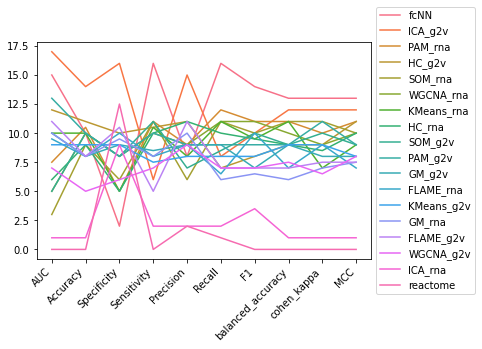

In [658]:
n = df_sorted.shape[1]
pal = sns.color_palette("husl", n)
for i in range(n):
    plt.plot(df_sorted.T.iloc[i,:], label=df_sorted.columns[i], color=pal[i])
    plt.xticks(rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

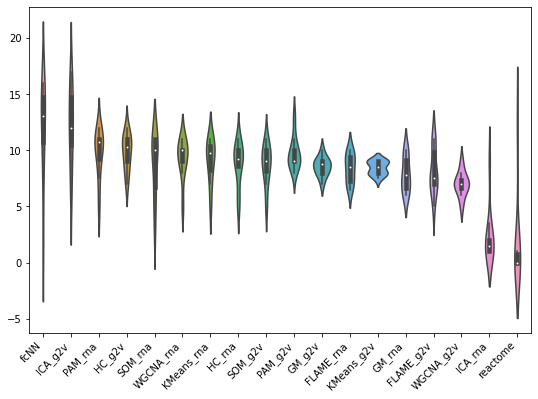

In [692]:
sns.violinplot(data=df_sorted)
plt.xticks(rotation=45, ha='right');

In [660]:
np.mean(rank_med_df, axis=1)

WGCNA_g2v      7.00
FLAME_rna      8.40
ICA_rna        2.35
KMeans_rna     9.10
GM_g2v         8.55
FLAME_g2v      8.15
HC_g2v         9.85
reactome       1.55
WGCNA_rna      9.30
PAM_g2v        9.70
fcNN          12.00
GM_rna         7.85
HC_rna         8.80
PAM_rna        9.80
ICA_g2v       12.20
SOM_g2v        8.75
KMeans_g2v     8.45
SOM_rna        8.80
dtype: float64

We can also plot the posterior distribution. 

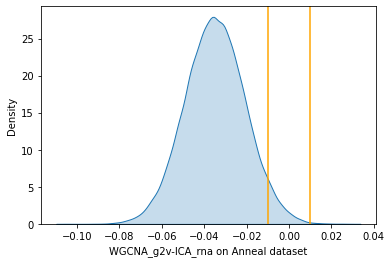

In [29]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snb
#generate samples from posterior (it is not necesssary because the posterior is a Student)
samples=bt.correlated_ttest_MC(x, rope=rope,runs=10,nsamples=50000)
#plot posterior
snb.kdeplot(samples, shade=True) 
#plot rope region
plt.axvline(x=-rope,color='orange')
plt.axvline(x=rope,color='orange')
#add label
plt.xlabel(names[0]+'-'+names[1]+' on Anneal dataset');

---

We will load the classification accuracies of NBC and AODE on the dataset *Audiology* from the file.  The classifiers have been evaluated by 10-runs of 10-fold cross-validation.

In [8]:
import numpy as np
Acc_nbc =  np.loadtxt('Data/nbc_audiology.csv',  delimiter=',', skiprows=1)
Acc_aode = np.loadtxt('Data/aode_audiology.csv', delimiter=',', skiprows=1)
names = ("AODE", "NBC")
diff=(Acc_nbc-Acc_aode)/100.0 #we consider the difference of accuracy scaled in (0,1)

In [3]:
import bayesiantests as bt
rope=0.01
left, within, right = bt.correlated_ttest(diff, rope=rope,runs=10,verbose=True,names=names)

P(AODE > NBC) = 0.08214267577999079, P(rope) = 0.9085092663989454, P(NBC > AODE) = 0.009348057821063849


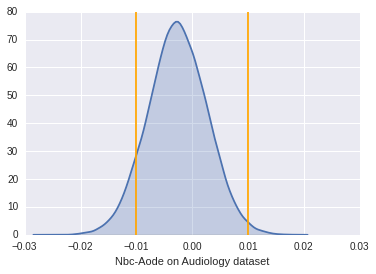

In [16]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snb
#generate samples from posterior (it is not necesssary because the posterior is a Student)
samples=bt.correlated_ttest_MC(diff, rope=rope,runs=10,nsamples=50000)
#plot posterior
snb.kdeplot(samples, shade=True) 
#plot rope region
plt.axvline(x=-rope,color='orange')
plt.axvline(x=rope,color='orange')
#add label
plt.xlabel('Nbc-Aode on Audiology dataset');

## References 

`@ARTICLE{bayesiantests2016,
   author = {{Benavoli}, A. and {Corani}, G. and {Demsar}, J. and {Zaffalon}, M.},
   title = "{Time for a change: a tutorial for comparing multiple classifiers through Bayesian analysis}",
   journal = {ArXiv e-prints},
   archivePrefix = "arXiv",
   eprint = {1606.04316},
   url={https://arxiv.org/abs/1606.04316},
   year = 2016,
   month = jun
}`

`@article{corani2015a,
  year = {2015},
  volume = {100},
  number = {2},
  journal = {Machine Learning},
  doi = {10.1007/s10994-015-5486-z},
  title = {{A Bayesian approach for comparing cross-validated algorithms on multiple data sets}},
  publisher = {Springer US},
  author = {Corani, Giorgio and Benavoli, Alessio},
  pages = {285--304},
  url = {http://www.idsia.ch/~alessio/corani2015a.pdf}
}`